In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose, AveragePooling2D, Add
from scipy.interpolate import RectBivariateSpline
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Boundary import Boundary1D
from collections.abc import Iterable
import itertools, h5py
from multiprocessing import Pool as ThreadPool
opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
conf = tf.ConfigProto(gpu_options=opts)
tfe.enable_eager_execution(config=conf)

In [2]:
class Upsample(tf.keras.layers.Layer):
    def __init__(self, upsample_ratio = (2,2), output_dtype = tf.float32, data_format = 'channels_first', resize_method = tf.image.ResizeMethod.BICUBIC, **kwargs):
        super(Upsample, self).__init__(**kwargs)
        self.output_dtype = output_dtype
        self.data_format = data_format
        self.resize_method = resize_method
        if not isinstance(upsample_ratio, Iterable):
            self.upsample_ratio = (upsample_ratio, upsample_ratio)
        else:
            self.upsample_ratio = upsample_ratio
            
    def build(self, input_shape):
        super(Upsample, self).build(input_shape)
        
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            return tf.TensorShape(list(input_shape)[0:2] + [self.upsample_ratio[0] * input_shape[-2], self.upsample_ratio[1] * input_shape[-1]])
        else:
            return tf.TensorShape([input_shape[0], self.upsample_ratio[0] * input_shape[-3], self.upsample_ratio[1] * input_shape[-2], input_shape[-1]])
    
#     def upsample(self, inp):
#         dummy_coords_inp = (np.linspace(0,1,int(inp.shape[-2])), np.linspace(0,1,int(inp.shape[-1])))
#         dummy_coords_out = (np.linspace(0,1,int(self.compute_output_shape(inp.shape)[-2])),np.linspace(0,1,int(self.compute_output_shape(inp.shape)[-1])))
#         #pdb.set_trace()
#         res = []
#         for i in range(inp.shape[0]):
#             spl = RectBivariateSpline(dummy_coords_inp[0], dummy_coords_inp[1], np.array(inp[i,...]))
#             res.append(spl(dummy_coords_out[0], dummy_coords_out[1]))
#         return tf.dtypes.cast(np.array(res), dtype=self.output_dtype)
    
#     @tf.contrib.eager.defun
#     def upsample_wrap(self,inp):
#         return tf.map_fn(self.upsample, inp)
        
    def call(self, inputs):
#         return self.upsample_wrap(inputs)
        if self.data_format == 'channels_first':
            return tf.transpose(tf.image.resize_images(tf.transpose(inputs, (0,2,3,1)), tf.multiply(self.upsample_ratio, inputs.shape[2:]), align_corners=True, method=self.resize_method), (0,3,1,2))
        else:
            return tf.image.resize_images(inputs, tf.multiply(self.upsample_ratio, inputs.shape[1:-1]), align_corners=True, method=self.resize_method)
        

In [3]:
def poisson_matrix(m,n):
    '''
    Generates the matrix A to express the Poisson equation in the form Ax=b for an m-by-n grid
    
    Them matrix returned shall be (m-2)*(n-2)-by-(m-2)*(n-2) in size
    
    CURRENTLY ONLY WORKS FOR SQUARE DOMAINS!!!!
    '''
    m = m-2
    n = n-2
    
    D = np.zeros((m,m), dtype = np.float64)
    i,j = np.indices(D.shape)
    D[i==j] = 4.0
    D[i==j-1] = -1.0
    D[i==j+1] = -1.0
    
    S = -np.eye(D.shape[0], dtype = np.float64)
    
    P = np.zeros((m*n,m*n), dtype = np.float64)
    ind = np.arange(0,m*(n+1), m)
    
    for i in range(len(ind)-1):
        P[ind[i]:ind[i+1], ind[i]:ind[i+1]] = D
        try:
            P[ind[i+1]:ind[i+2], ind[i]:ind[i+1]] = S
        except:
            pass
        try:
            P[ind[i-1]:ind[i], ind[i]:ind[i+1]] = S
        except:
            pass
    return P

def generate_random_RHS(n, n_controlpts = None, n_outputpts = None, s = 5, domain = [0,1,0,1]):
    
    '''
    This function generates random smooth RHS 'functions' defined pointwise using bivariate splines. 
    n: no. of random RHSes to generate
    n_controlpts: no. of control pts of the spline. Smaller values lead to 'smoother' results
    n_outputpts: no. of gridpoints in each direction of the output 
    s: see parameter s in scipy.interpolate.RectBivariateSpline
    domain: [x_min, x_max, y_min, y_max]
    '''
    
    
    if isinstance(n, Iterable):
        n_controlpts = n[1]
        n_outputpts = n[2]
        try:
            s = n[3]
        except:
            pass
        try:
            domain = n[4]
        except:
            pass
        n = n[0]
    
    x = np.linspace(domain[0], domain[1], n_controlpts)
    y = np.linspace(domain[2], domain[3], n_controlpts)
    if n_controlpts != n_outputpts:
        x_out = np.linspace(domain[0], domain[1], n_outputpts)
        y_out = np.linspace(domain[2], domain[3], n_outputpts)
    else:
        x_out = x
        y_out = y
            
    out = []
    for i in range(n):
        spl = RectBivariateSpline(x,y,2*np.random.rand(len(x), len(y))-1, s=s)
        out.append(spl(x_out,y_out))
    return np.array(out)
    

def poisson_RHS(F, boundaries = None, h = None):
    '''
    Generates the RHS vector b of a discretized Poisson problem in the form Ax=b.
    h = grid spacing
    boundaries = dict containing entries 'top', 'bottom', 'right' and 'left' which correspond to the Dirichlet BCs at these boundaries. Each entry must be a vector of length m or n, where m and n are defined as in te function poisson_matrix
    F = an m by n matrix containing the RHS values of the Poisson equation
    
    (i.e. this function merely takes the BC information and the array from generate_random_RHS to provide the RHS for the matrix eq. form)
    '''
    
    if isinstance(F, Iterable):
        boundaries = F[1]
        h = F[2]
        F = F[0]
    
    F = -h**2 * F
    F[...,1:-1,1] = F[...,1:-1,1] + np.array(boundaries['top'])[1:-1]
    F[...,1:-1,-2] = F[...,1:-1,-2] + np.array(boundaries['bottom'])[1:-1]
    F[...,1,1:-1] = F[...,1,1:-1] + np.array(boundaries['left'])[1:-1]
    F[...,-2,1:-1] = F[...,-2,1:-1] + np.array(boundaries['right'])[1:-1]
    
    return F[...,1:-1,1:-1].reshape(list(F[...,1:-1,1:-1].shape[:-2]) + [np.prod(F[...,1:-1,1:-1].shape[-2:])])
 
def generate_dataset(batch_size, n, h, boundaries, n_batches = 1, rhs_range = [-1,1]):
    lhs = tf.constant(poisson_matrix(n,n), dtype=tf.float64)
    lhs_chol = tf.linalg.cholesky(lhs)
    
    def chol(r):
        return tf.linalg.cholesky_solve(lhs_chol, tf.transpose(tf.stack([r])))
    
    @tf.contrib.eager.defun
    def chol_solve(rhs_arr):
        return tf.map_fn(chol, rhs)
    
    #pdb.set_trace()
    pool = ThreadPool(n_batches)
    F = pool.map(generate_random_RHS, zip(itertools.repeat(batch_size, n_batches), itertools.repeat(10), itertools.repeat(n), itertools.repeat(5), itertools.repeat([0,n*h,0,n*h])))
    rhs = tf.concat(pool.map(poisson_RHS, zip(F, itertools.repeat(boundaries), itertools.repeat(h))), axis=0)
    
    soln = np.zeros((n_batches * batch_size, n, n), dtype = np.float64)
    soln[...,:,0] = boundaries['top']
    soln[...,:,-1] = boundaries['bottom']
    soln[...,0,:] = boundaries['left']
    soln[...,-1,:] = boundaries['right']
    soln[:,1:-1,1:-1] = tf.reshape(chol_solve(rhs), (n_batches * batch_size, n-2, n-2))
    #soln = chol_solve(rhs)
    
    #return tf.reshape(soln, (n_batches, batch_size, lhs_chol.shape[0])), tf.reshape(F, (n_batches, batch_size, F.shape[-2], F.shape[-1]))
    return tf.reshape(soln, (n_batches*batch_size, 1, soln.shape[-2], soln.shape[-1])), tf.reshape(tf.concat(F, axis = 0), (n_batches*batch_size, 1, F[0].shape[-2], F[0].shape[-1]))


In [4]:
ntest = 64
h = 0.05
boundary_top = Boundary1D('Dirichlet', [(0,ntest*h),(ntest*h,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_right = Boundary1D('Dirichlet', [(ntest*h,ntest*h),(ntest*h,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_bottom = Boundary1D('Dirichlet', [(ntest*h,0),(0,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_left = Boundary1D('Dirichlet', [(0,0),(0,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)

In [41]:
import time
t0 = time.time()
soln,F = generate_dataset(batch_size=2000, n = ntest, h = h, n_batches=20, boundaries={'top': boundary_top.RHS_evaluate(np.linspace(boundary_top.t.min(),boundary_top.t.max(),ntest)), 'right': boundary_right.RHS_evaluate(np.linspace(boundary_right.t.min(),boundary_right.t.max(),ntest)), 'bottom': boundary_bottom.RHS_evaluate(np.linspace(boundary_bottom.t.min(),boundary_bottom.t.max(),ntest)), 'left': boundary_left.RHS_evaluate(np.linspace(boundary_left.t.min(),boundary_left.t.max(),ntest))})
t1 = time.time()
print('Generation of training data took ' + str(t1-t0) + ' seconds')
with h5py.File('dataset8.h5', 'w') as hf:
    hf.create_dataset('soln', data=soln)
    hf.create_dataset('F', data=F)

Generation of training data took 717.9840817451477 seconds


In [5]:
for i in range(6,9):
    with h5py.File('dataset' + str(i) + '.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            train_data = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            train_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [6]:
import time
t0 = time.time()
soln_valid,F_valid = generate_dataset(batch_size=1000, n = ntest, h = h, n_batches=2, boundaries={'top': boundary_top.RHS_evaluate(np.linspace(boundary_top.t.min(),boundary_top.t.max(),ntest)), 'right': boundary_right.RHS_evaluate(np.linspace(boundary_right.t.min(),boundary_right.t.max(),ntest)), 'bottom': boundary_bottom.RHS_evaluate(np.linspace(boundary_bottom.t.min(),boundary_bottom.t.max(),ntest)), 'left': boundary_left.RHS_evaluate(np.linspace(boundary_left.t.min(),boundary_left.t.max(),ntest))})
t1 = time.time()
print('Generation of validation data took ' + str(t1-t0) + ' seconds')

Generation of validation data took 38.78255367279053 seconds


In [5]:
# with h5py.File('dataset' + str(4) + '.h5', 'r') as hf:
#         F_valid = np.array(hf.get('F'), dtype = np.float64)
#         soln_valid = np.array(hf.get('soln'), dtype = np.float64)

In [7]:
shuffle_size = 100000
batch_size = 2000
train_data = train_data.shuffle(shuffle_size).batch(batch_size)
dataset_validation = tf.data.Dataset.from_tensor_slices((F_valid, soln_valid)).shuffle(shuffle_size).batch(100)
#del F, soln#, F_valid, soln_valid

In [8]:
input_0 = Input(shape=(1,ntest,ntest,))
conv_1_0 = Conv2D(filters = 5, kernel_size = 3, activation=tf.nn.relu, data_format='channels_first', padding='same')(input_0)

conv_2_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.relu, data_format='channels_first', padding='same')(conv_1_0)
pool_2_0 = AveragePooling2D(data_format = 'channels_first')(conv_2_0)
pool_2_1 = AveragePooling2D(data_format = 'channels_first')(pool_2_0)

conv_3_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.relu, data_format = 'channels_first', padding='same')(conv_2_0)
conv_3_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.relu, data_format = 'channels_first', padding='same')(pool_2_0)
conv_3_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.relu, data_format = 'channels_first', padding='same')(pool_2_1)
#transposeconv_3_1 = Conv2DTranspose(filters = 8, kernel_size = 3, strides = 2, activation = tf.nn.relu, data_format = 'channels_first', padding='same')(conv_3_1)
#transposeconv_3_2 = Conv2DTranspose(filters = 8, kernel_size = 3, strides = 4, activation = tf.nn.relu, data_format = 'channels_first', padding='same')(conv_3_2)
#upsample_3_1 = UpSampling2D(size=(2,2), data_format = 'channels_first', interpolation = 'bilinear')(conv_3_1)
#upsample_3_2= UpSampling2D(size=(4,4), data_format = 'channels_first', interpolation = 'bilinear')(conv_3_2)
upsample_3_1 = Upsample()(conv_3_1)
upsample_3_2 = Upsample(4)(conv_3_2)
#merge_3_0 = Add()([conv_3_0, transposeconv_3_1, transposeconv_3_2])
merge_3_0 = Add()([conv_3_0, upsample_3_1, upsample_3_2])

conv_4_0 = Conv2D(filters = 8, kernel_size = 1, activation = tf.nn.relu, data_format = 'channels_first', padding='same')(merge_3_0)

conv_5_0 = Conv2D(filters = 1, kernel_size = 1, activation = 'linear', data_format = 'channels_first', padding='same')(conv_4_0)
final_activation = tf.keras.layers.PReLU()(conv_5_0)
a = Model(input_0, final_activation)

In [12]:
a.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-3), loss = tf.losses.mean_squared_error, metrics = ['accuracy'])
a.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 64, 64)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 64, 64)    50          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 64, 64)    368         conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 8, 32, 32)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
average_po

In [14]:
a.fit(train_data, steps_per_epoch=8, epochs=7, validation_data=dataset_validation, validation_steps=2)

Epoch 1/7
8/8 [==============================] - 29s 4s/step - loss: 2.2234e-04 - acc: 0.9998 - val_loss: 0.0400 - val_acc: 0.1400
Epoch 2/7
8/8 [==============================] - 26s 3s/step - loss: 2.1176e-04 - acc: 0.9998 - val_loss: 0.0348 - val_acc: 0.1409
Epoch 3/7
8/8 [==============================] - 26s 3s/step - loss: 2.0222e-04 - acc: 0.9998 - val_loss: 0.0295 - val_acc: 0.1465
Epoch 4/7
8/8 [==============================] - 26s 3s/step - loss: 1.9463e-04 - acc: 0.9999 - val_loss: 0.0365 - val_acc: 0.1677
Epoch 5/7
8/8 [==============================] - 26s 3s/step - loss: 1.8627e-04 - acc: 0.9999 - val_loss: 0.0322 - val_acc: 0.1334
Epoch 6/7
8/8 [==============================] - 26s 3s/step - loss: 1.7986e-04 - acc: 0.9998 - val_loss: 0.0377 - val_acc: 0.1459
Epoch 7/7
8/8 [==============================] - 26s 3s/step - loss: 1.7993e-04 - acc: 0.9998 - val_loss: 0.0316 - val_acc: 0.1215


In [205]:
# a.save_weights('model.h5')

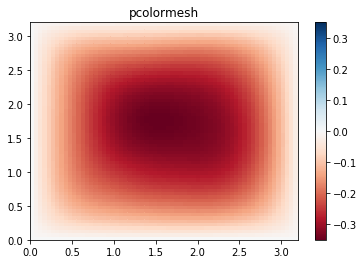

In [15]:
p = np.random.randint(0,F_valid.shape[0])
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
z = a.predict(tf.expand_dims(F[p,...], axis=0))[0,0,...]
#z = soln[p,0,...]
#z = generate_random_RHS(10, n_controlpts=10, n_outputpts=64)[4,:,:]
#z = a.predict(tf.expand_dims(F_valid[p,...], axis=0))[0,0,...] - soln_valid[p,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

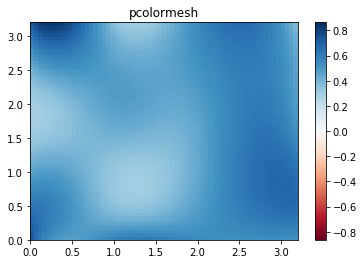

In [17]:
#soln_valid,F_valid = generate_dataset(batch_size=50, n = ntest, h = h, n_batches=1, boundaries={'top': boundary_top.RHS_evaluate(np.linspace(boundary_top.t.min(),boundary_top.t.max(),ntest)), 'right': boundary_right.RHS_evaluate(np.linspace(boundary_right.t.min(),boundary_right.t.max(),ntest)), 'bottom': boundary_bottom.RHS_evaluate(np.linspace(boundary_bottom.t.min(),boundary_bottom.t.max(),ntest)), 'left': boundary_left.RHS_evaluate(np.linspace(boundary_left.t.min(),boundary_left.t.max(),ntest))})
#p = np.random.randint(0,F_valid.shape[0])
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
z = F[p,0,...]
#z = soln[p,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [186]:
i = np.random.randint(1,ntest-2)
j = np.random.randint(1,ntest-2)
p = np.random.randint(0,soln_valid.shape[0]-1)
print((-4 * soln_valid[p,0,i,j] + soln_valid[p,0,i,j-1] + soln_valid[p,0,i-1,j] + soln_valid[p,0,i+1,j] + soln_valid[p,0,i,j+1])/(h**2))
example_soln = a.predict(tf.expand_dims(F_valid[p,...], axis=0))
print((-4 * example_soln[0,0,i,j] + example_soln[0,0,i,j-1] + example_soln[0,0,i-1,j] + example_soln[0,0,i+1,j] + example_soln[0,0,i,j+1])/(h**2))
print(F_valid[p,0,i,j])
print(soln_valid[p,0,i,j])

tf.Tensor(0.5087829935637943, shape=(), dtype=float64)
0.3638863563537597
tf.Tensor(0.5087829935638285, shape=(), dtype=float64)
tf.Tensor(-0.1960798744723582, shape=(), dtype=float64)


In [201]:
X,Y = np.meshgrid(np.linspace(0,1,20),np.linspace(0,1,20))
Z_m = np.array([[np.sin(np.pi*(X+Y)), np.cos(np.pi * (X+Y))] , [np.exp(-X**2 * Y**2), np.tan(np.multiply(X,Y))]])
#Z_m = tf.expand_dims(Z, axis = 0)
ur = 3
b = BilinearUpsample(ur)(input_0)
model1 = Model(input_0, b)

In [32]:
Z_m.shape

TensorShape([Dimension(2), Dimension(1), Dimension(20), Dimension(20)])

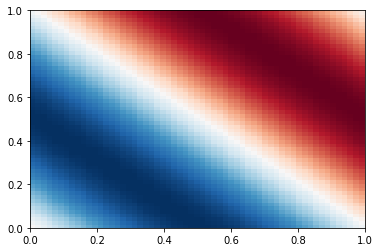

In [202]:
X0, Y0 = np.meshgrid(np.linspace(0,1,X.shape[0]*ur),np.linspace(0,1,X.shape[0]*ur))
fig, ax = plt.subplots()
c = ax.pcolormesh(X0, Y0, model1(Z_m)[0,0,...], cmap='RdBu')

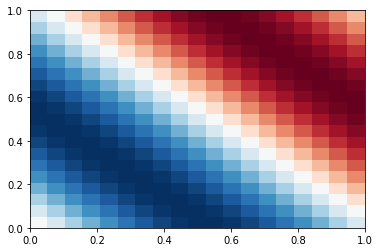

In [24]:
fig, ax = plt.subplots()
c = ax.pcolormesh(X, Y, Z_m[0,0,...], cmap='RdBu')

In [27]:
np.mean(np.abs(a.predict(F_valid) - soln_valid))

0.008573481361783628

In [160]:
timeit a.predict(tf.expand_dims(F_valid[0,...], axis=0))

10.9 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [187]:
timeit a.predict(F_valid[0:1000,...])

673 ms ± 87.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [192]:
lhs = poisson_matrix(64,64)
lhs_chol = tf.to_float(tf.linalg.cholesky(lhs))
print(lhs_chol.shape)
rhs = tf.constant(np.random.rand((64-2)**2,1000ur), dtype=tf.float32)
print(rhs.shape)

(3844, 3844)
(3844, 1000)


In [193]:
timeit tf.linalg.cholesky_solve(lhs_chol,rhs)

31 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:

b.